In [120]:
import os
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import cpi
import pymongo
from tqdm import tqdm
from scipy import stats
import math
import numpy as np
import pandas as pd

In [121]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["imdb"]
imdb = db['imdb_cleaned']

In [122]:
num_movies = imdb.count_documents({})
num_movies

8181

In [123]:
content_dict = {}

for movie in imdb.find():
    rev = movie['cleaned_Revenue']
    cr = movie['cleaned_contentRating']

    if(cr not in content_dict):
        content_dict[cr] = []
    content_dict[cr].append(rev)

In [124]:
for cr in content_dict:
    print(cr, len(content_dict[cr]))

PG-13 2154
R 3753
PG 1245
TV-MA 52
G 184
Unrated 72
NC-17 14
Not Rated 628
Approved 9
X 1
M 2
M/PG 1
GP 5
TV-PG 15
TV-14 36
TV-Y7 3
Passed 1
TV-G 6


In [126]:
clusters = {
    'PG'        : ['PG-13', 'PG'],
    'R'         : ['R', 'NC-17'],
    'Others'    : ["Approved", "X", "M", "M/PG", "GP", "Passed", "Passed"],
    'TV'        : ["TV-MA", "TV-PG", "TV-14", "TV-Y7", "TV-G"],
    'Unrated'   : ["Unrated", "Not Rated"] 
}

In [127]:
def getCluster(key):
    for cluster in clusters:
        if(key in clusters[cluster]):
            return cluster
    return key

In [128]:
content_dict2 = {}

for key in content_dict:
    cluster = getCluster(key)
    if(cluster not in content_dict2):
        content_dict2[cluster] = content_dict[key]
    else:
        content_dict2[cluster] += content_dict[key]

In [129]:
def plotBars(dct, isList = False):
    xrr = []
    yrr = []
    for key in dct:
        xrr.append(key)
        if(isList == True):
            yrr.append(len(dct[key]))
        else:
            yrr.append(dct[key])
    fig = go.Figure([go.Bar(x=xrr, y=yrr)])
    return fig

In [130]:
fig = plotBars(content_dict, isList=True)
fig.show()

In [131]:
fig = plotBars(content_dict2, isList=True)
fig.show()

In [132]:
avg_rev = {}
for key in content_dict:
    content_dict[key] = np.array(content_dict[key])
    avg_rev[key] = content_dict[key].mean()

In [133]:
fig = plotBars(avg_rev)
fig.show()

In [134]:
avg_rev2 = {}
for key in content_dict2:
    content_dict2[key] = np.array(content_dict2[key])
    avg_rev2[key] = content_dict2[key].mean()

In [135]:
fig = plotBars(avg_rev2)
fig.show()

In [136]:
from scipy.stats import ks_2samp
import numpy as np

np.random.seed(123456)
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
z = np.random.normal(1.1, 0.9, 1000)

print(ks_2samp(x, y))

print(ks_2samp(x, z))

KstestResult(statistic=0.053, pvalue=0.12051526066065596)
KstestResult(statistic=0.449, pvalue=3.866163455650273e-91)


In [137]:
ks_2samp(content_dict['PG-13'], content_dict['R'])

KstestResult(statistic=0.24863369221244588, pvalue=8.38232708780114e-98)

In [138]:
arr = content_dict['PG-13']

In [139]:
import random
random.shuffle(arr)

In [140]:
middle = len(arr)//2
ks_2samp(arr[0:middle], arr[middle:len(arr)])

KstestResult(statistic=0.03978049371602673, pvalue=0.12966681601782626)

In [172]:
stat_matrix = {}
pvalue_matrix = {}

for ik in content_dict:
    stat_matrix[ik] = {}
    pvalue_matrix[ik] = {}
    for jk in content_dict:
        ks = ks_2samp(content_dict[ik], content_dict[jk])
        stat_matrix[ik][jk] = ks.statistic
        pvalue_matrix[ik][jk] = ks.pvalue
        if(jk == ik):
            break

In [173]:
stat_df = pd.DataFrame(stat_matrix)

In [174]:
stat_df

,PG-13,R,PG,TV-MA,G,Unrated,NC-17,Not Rated,Approved,X,M,M/PG,GP,TV-PG,TV-14,TV-Y7,Passed,TV-G
PG-13,0.0,0.248634,0.013381,0.695023,0.127928,0.635073,0.402072,0.619987,0.339527,0.589291,0.465137,0.865843,0.415769,0.739276,0.725777,0.782877,0.730215,0.747132
R,NaN,0.000000,0.254919,0.510137,0.326648,0.438294,0.178543,0.423754,0.204169,0.651181,0.702681,0.681179,0.227024,0.568021,0.540697,0.566322,0.893018,0.622556
PG,NaN,NaN,0.000000,0.686862,0.123752,0.637057,0.405795,0.622389,0.329909,0.592771,0.453815,0.856225,0.419277,0.730120,0.718608,0.787952,0.729317,0.741767
TV-MA,NaN,NaN,NaN,0.000000,0.710404,0.086071,0.571429,0.098044,0.445959,0.928571,0.928571,0.821429,0.589286,0.259524,0.090278,0.357143,0.982143,0.220238
G,NaN,NaN,NaN,NaN,0.000000,0.665466,0.460404,0.653628,0.350400,0.614130,0.510870,0.869565,0.452174,0.752536,0.742150,0.793478,0.608696,0.762681
Unrated,NaN,NaN,NaN,NaN,NaN,0.000000,0.530000,0.018362,0.462030,0.940000,0.955714,0.751429,0.560000,0.250952,0.122857,0.324286,0.985714,0.223333
NC-17,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.520928,0.296992,0.785714,0.785714,0.571429,0.314286,0.585714,0.595238,0.595238,0.928571,0.619048
Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.454660,0.933121,0.950637,0.737261,0.552548,0.248832,0.127389,0.320064,0.984076,0.231423
Approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.578947,0.631579,0.526316,0.315789,0.526316,0.442982,0.526316,0.842105,0.526316
X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,0.800000,1.000000,0.944444,1.000000,1.000000,1.000000


In [175]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [176]:
def plotMatrix(dct2D):
    # print(dct2D)
    arr2D = []
    for ik in dct2D:
        arr1D = []
        for jk in dct2D[ik]:
            arr1D.append(dct2D[ik][jk])
        arr2D.append(arr1D)
    df_cm = pd.DataFrame(arr2D, index = list(dct2D.keys()),
                  columns = list(dct2D.keys()))
    plt.figure(figsize = (20,14))
    sn.heatmap(df_cm, annot=True)
    plt.show()

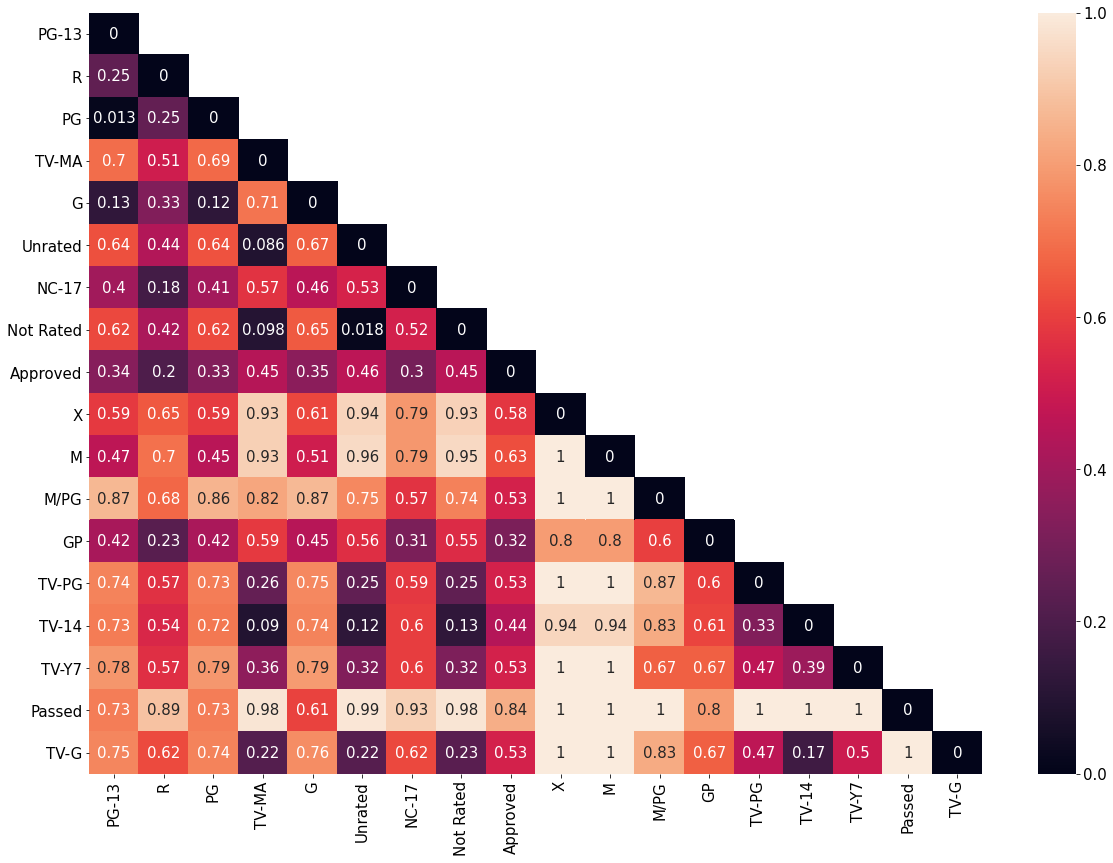

In [182]:
plt.rcParams.update({'font.size': 15})
plotMatrix(stat_matrix)

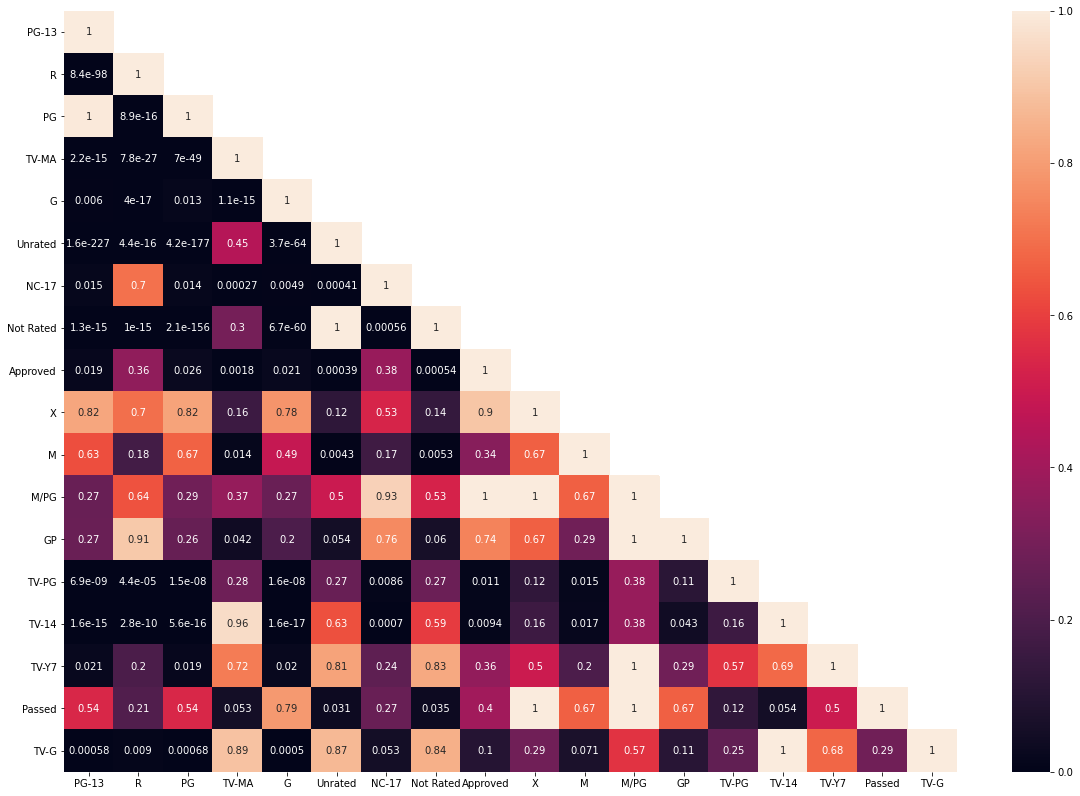

In [184]:
plt.rcParams.update({'font.size': 10})
plotMatrix(pvalue_matrix)

In [180]:
stat_matrix2 = {}
pvalue_matrix2 = {}

for ik in content_dict2:
    stat_matrix2[ik] = {}
    pvalue_matrix2[ik] = {}
    for jk in content_dict2:
        ks = ks_2samp(content_dict2[ik], content_dict2[jk])
        stat_matrix2[ik][jk] = ks.statistic
        pvalue_matrix2[ik][jk] = ks.pvalue
        if(ik == jk):
            break

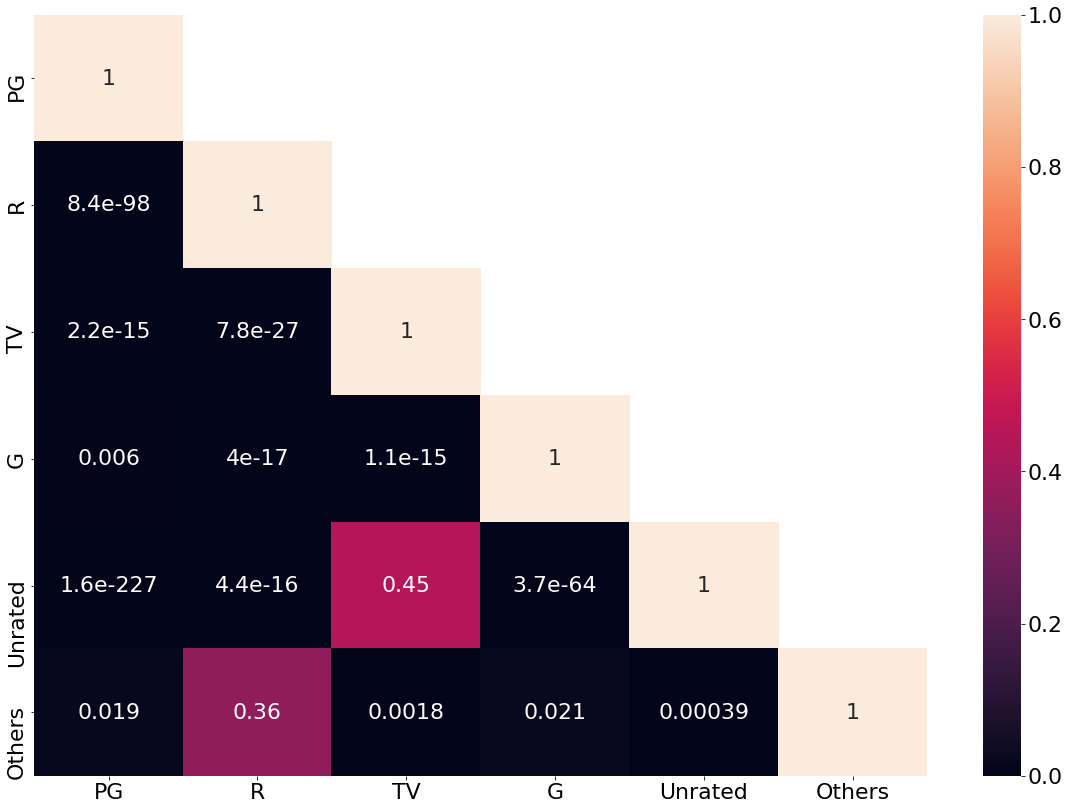

In [181]:
plt.rcParams.update({'font.size': 22})
plotMatrix(pvalue_matrix2)